# Классификация отзывов пользователей по токсичности

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

**Цель проетка** обучить различные модели, классифицирующие комментарии на позитивные и негативные, и выбрать среди них лучшую. Для этого нам предоставлен набор данных с разметкой токсичности комментариев. Критерием хорошей работы модели является значение *F1-меры* не ниже **0.75**.

Проект будет проходить в нексколько **этапов**:

<p><b>1</b> Обзор и подготовка данных
<p><b>2</b> Лемматизация текстов
<p><b>3</b> Построение и обучение моделей
<p>&nbsp;&nbsp;&nbsp;&nbsp; <b>3.1</b> Разделение на выборки
<p>&nbsp;&nbsp;&nbsp;&nbsp; <b>3.2</b> Создание пайпланов
<p>&nbsp;&nbsp;&nbsp;&nbsp; <b>3.3</b> <i>Логистическая регрессия</i>
<br>&nbsp;&nbsp;&nbsp;&nbsp; <b>3.4</b> <i>Машина опопрных векторов</i>
<br>&nbsp;&nbsp;&nbsp;&nbsp; <b>3.5</b> <i>Градиентный бустинг</i>
<p><b>4</b> Выбор и тестирование лучшей модели
<p>&nbsp;&nbsp;&nbsp;&nbsp; <b>4.1</b> Сравнение результатов обучения
<p>&nbsp;&nbsp;&nbsp;&nbsp; <b>4.2</b> Тестирование выбранной модели
<p><b>5</b> Выводы

## Обзор и подготовка данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords

from tqdm import notebook

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from catboost import CatBoostClassifier

C:\Users\Asus\anaconda3\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [2]:
# чтение файла с данными и его сохранение в таблице
try:
    df = pd.read_csv('toxic_comments.csv', on_bad_lines='skip')
except:
    df = pd.read_csv('/datasets/toxic_comments.csv', on_bad_lines='skip')

In [3]:
# вывод первых пяти строк
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
# вывод общей информации
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159451 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159451 non-null  object
 1   toxic   159320 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


Из первых пяти строк таблицы мы видим, что комментарии написаны на английском языке. Из общей информации можно заметить, что в целевом признаке `toxic` присутствуют пропуски, а данные записаны в строковом представлении. Посмотрим на уникальные значения данного признака.

In [5]:
# вывод уникальных значений целевого признака
df['toxic'].unique()

array(['0', '1', nan, ' removed also by ALR. Why.',
       ' and possibly edit the article. Thank you for your time.99.41.251.5 (talk)”',
       ' but you judge.', ' and on pages like votes for deletion',
       ' Sime Darby is poised with the potential for more in the future"""". This statement is also somewhat judgemental.',
       ' anything yet?',
       " Wikipedia's most-viewed board has declared a specific living person has terminal cancer.",
       ',0\nquestion', ' re:Open access publishing',
       ',0\nSockpuppet Investigation of User:Anyones Else For Nutley ',
       ' you are absolutely correct.  Keep up the good work.  ',
       " I suspect there's a great deal of history that I'm woefully unaware of.  Thank you. —   \xa0?\xa0 ",
       ' though a minority opinion."""" - Enough evidence to include parent systems in Infobox.',
       ' you will be blocked from editing.   (T) ',
       ' Time Magazine Article & The New Statesmen. ',
       ' in that it infers that Noel Stan

Мы видим, что помимо 0, 1 и `np.nan`, в целевой признак также попала небольшая часть комментариев. Удалим проблемные строки. Приведем значения целевого признака к целочисленному типу данных `int`. Посчитаем долю потерянных данных.

In [6]:
# удаление проблемных строк
new_df = df[df['toxic'].isin(['0', '1'])]

In [7]:
# приведение значений целевого признака к типу данных `int`
new_df.loc[:, 'toxic'] = new_df.loc[:, 'toxic'].astype('int')

C:\Users\Asus\AppData\Local\Temp\ipykernel_17308\1294461992.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.loc[:, 'toxic'] = new_df.loc[:, 'toxic'].astype('int')


In [8]:
# вывод процента потерянных данных
print('{:.1%}'.format((df.shape[0] - new_df.shape[0]) / df.shape[0] ))

0.1%


Доля потерянных данных составила всего **0.1%**. Рассмотрим распределение *целевого признака*.

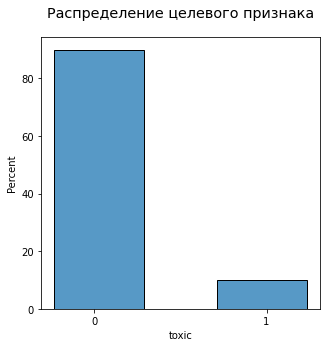

In [9]:
# вывод распределения целевого признака
fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(data=new_df, x='toxic', ax=ax, stat='percent', shrink=10)
ax.set_title('Распределение целевого признака', fontsize='x-large', y=1.05)
ax.set_xticks([0, 1])

Как оказалось, в целевом признаке наблюдатеся сильный дисбаланс. Соотношение между количеством токсичных и не токсичных комментариев — **1:9**. Учтем это при обучении моделей.

## Лемматизация текстов

Лемматизируем исходные тексты. Воспользуемся возможностями библиотеки `spacy`. Отметим, что в отличие от `nltk`, `spacy` в несколько раз быстрее распознает часть речи слова. Создадим объект, загрузив пакет `en_core_web_sm` из данной библиотеки.

In [10]:
# инициализация объекта класса `en_core_web_sm`
spacy = spacy.load('en_core_web_sm')

C:\Users\Asus\anaconda3\lib\site-packages\spacy\util.py:865: UserWarning: [W095] Model 'en_core_web_sm' (3.3.0) was trained with spaCy v3.3 and may not be 100% compatible with the current version (3.4.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Напишем функцию, которая будет лемматизировать исходные тексты.

In [11]:
# создание функции, лемматизирующей тексты
def lemmatize_text(text):
    return ' '.join([token.lemma_ for token in spacy(text)])

Лемматизация, учитывающая часть речи слова, занимает достаточно долгое время. Чтобы визуализировать процесс выполнения кода воспользуемся функцией `notebook.tqdm` из библиотеки `tqdm`. Чтобы избежать проблем, связанных с нехваткой оперативной памяти, разобьем данные на 1000 батчей.

In [12]:
%%time
# лемматизация текстов
batch_size = 1000
for i in notebook.tqdm(range(new_df.shape[0] // batch_size)):
    if i != new_df.shape[0] // batch_size - 1:
        batch = new_df.loc[i*batch_size:(i+1)*batch_size, 'text']
        new_df.loc[i*batch_size:(i + 1)*batch_size, 'lemmatized_text'] = batch.apply(lemmatize_text)
    else:
        batch = new_df.loc[i*batch_size::, 'text']
        new_df.loc[i*batch_size::, 'lemmatized_text'] = batch.apply(lemmatize_text)
new_df = new_df.reindex(columns=['text', 'lemmatized_text', 'toxic'])

  0%|          | 0/159 [00:00<?, ?it/s]

<timed exec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: total: 25min 9s
Wall time: 25min 23s


Приведем все комментарии к нижнему регистру и удалим из них лишние символы, оставив только латинские буквы. 

In [13]:
# удаление лишних символов из лемматизированных текстов
new_df['lemmatized_text'] = new_df['lemmatized_text'].apply(lambda word: re.sub(r'[^a-zA-Z]', ' ', word.lower()))

Снова выведем первые 5 строк получившегося датасета.

In [14]:
# вывод первых 5 строки
new_df.head(5)

,text,lemmatized_text,toxic
0,Explanation\nWhy the edits made under my usern...,explanation why the edit make under my usern...,0
1,D'aww! He matches this background colour I'm s...,d aww he match this background colour i be s...,0
2,"Hey man, I'm really not trying to edit war. It...",hey man i be really not try to edit war it...,0
3,"""\nMore\nI can't make any real suggestions on ...",more i can not make any real suggestion ...,0
4,"You, sir, are my hero. Any chance you remember...",you sir be my hero any chance you rememb...,0


Как мы видим, работа с текстом была проведена успешно. Текст лемматизирован, все лишние символы заменены на пробелы.

## Построение и обучение моделей

Мы обучим два типа линейных моделей:

* модель *логистической регрессии*, основанную на вероятностном подходе 
* *машину опорных векторов*, основанную на геометрическом подходе

Попробуем также ансамбль *решающих деревьев*, обученных методом *градиентного бустинга*. 

### Разделение на выборки

Раздедим данные на *обучающую* и *тестовую выборки* в соотношении **9:1**. Учтем, отмеченный ранее дисбаланс классов, стратифицировав данные по столбцу `toxic`.

In [15]:
# разделение данных на выборки
train_features, test_features, train_target, test_target = train_test_split(new_df['lemmatized_text'], new_df['toxic'],
                                                                            test_size=0.1, random_state=42, stratify=new_df['toxic'])

### Создание пайплайнов

Перед тем, как приступить к обучению моделей, приведем ранее лемматизированный текст к числовому виду с помощью меры *TF-IDF*. Для этого воспользуемся классом `TfidfVectorizer` библиотеки `sklearn`. Чтобы не возникло проблем с утечкой информации из *обучающей выборки* в *тестовую* при кросс-валидационном поиске лучшей модели, воспользуемся пайплайнами. Для удаления стоп-слов воспользуемся пакетом `nltk`.

In [16]:
# создание пайплайнов
nltk.download('stopwords') 
pipe_lr = make_pipeline(TfidfVectorizer(stop_words=nltk_stopwords.words('english')), LogisticRegression())

pipe_svc = make_pipeline(TfidfVectorizer(stop_words=nltk_stopwords.words('english')), LinearSVC(random_state=42))

pipe_cb = make_pipeline(TfidfVectorizer(stop_words=nltk_stopwords.words('english')), CatBoostClassifier(random_seed=42,
                                                                                                        verbose=False))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Линейная регрессия

Поиск оптимальных моделей будем производить с помощью кроссвалидационного поиска по сетке. Для этого воспользуемся классом `GridSearchCV` библиотеки `sklearn`. Параметр определяющий количество фолдов `cv` установим равным **4**.

Первыми обучим модели *логистической регрессии*. В качестве неизменяемых параметров установим `class_weight='balanced'` и `solver='liblinear'`. Изменяемым параметром будет *сила обратной регуляризации* `C`. Установим пределы поиска параметра **от 1 до 19 с шагом 2**.

In [17]:
%%time
# обучение моделей логистической регрессии
С_array = np.linspace(1, 19, 10)
param_grid = {'logisticregression__class_weight': ['balanced'], 'logisticregression__solver': ['liblinear'], 
              'logisticregression__C': С_array}

logistic_regression = GridSearchCV(pipe_lr, param_grid, scoring='f1', cv=4, verbose=2)
logistic_regression.fit(train_features, train_target)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] END logisticregression__C=1.0, logisticregression__class_weight=balanced, logisticregression__solver=liblinear; total time=   5.6s
[CV] END logisticregression__C=1.0, logisticregression__class_weight=balanced, logisticregression__solver=liblinear; total time=   5.7s
[CV] END logisticregression__C=1.0, logisticregression__class_weight=balanced, logisticregression__solver=liblinear; total time=   5.6s
[CV] END logisticregression__C=1.0, logisticregression__class_weight=balanced, logisticregression__solver=liblinear; total time=   5.5s
[CV] END logisticregression__C=3.0, logisticregression__class_weight=balanced, logisticregression__solver=liblinear; total time=   5.8s
[CV] END logisticregression__C=3.0, logisticregression__class_weight=balanced, logisticregression__solver=liblinear; total time=   5.8s
[CV] END logisticregression__C=3.0, logisticregression__class_weight=balanced, logisticregression__solver=liblinear; total 

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                   

### Машина опорных векторов

Далее обучим *машины опорных векторов* с линейными ядрами. Это оптимальный выбор при работе с большим количеством данных и признаков. В качестве изменяемого параметра также выберем *силу обратной регуляризации* `C`. Установим пределы поиска параметра **от 0.1 до 1.9 с шагом 0.2**.

In [18]:
%%time
# обучение машин опорных векторов
С_array = np.linspace(0.1, 1.9, 10)
param_grid = {'linearsvc__C': С_array}

svc = GridSearchCV(pipe_svc, param_grid, scoring='f1', cv=4, verbose=2)
svc.fit(train_features, train_target)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] END ...................................linearsvc__C=0.1; total time=   5.1s
[CV] END ...................................linearsvc__C=0.1; total time=   5.1s
[CV] END ...................................linearsvc__C=0.1; total time=   4.8s
[CV] END ...................................linearsvc__C=0.1; total time=   4.9s
[CV] END ...................................linearsvc__C=0.3; total time=   4.8s
[CV] END ...................................linearsvc__C=0.3; total time=   5.0s
[CV] END ...................................linearsvc__C=0.3; total time=   4.9s
[CV] END ...................................linearsvc__C=0.3; total time=   4.9s
[CV] END ...................................linearsvc__C=0.5; total time=   5.0s
[CV] END ...................................linearsvc__C=0.5; total time=   5.0s
[CV] END ...................................linearsvc__C=0.5; total time=   5.0s
[CV] END ...................................line

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                   

### Градиентный бустинг

Обучение *градиентным бустингом* времязатратно. Поэтому в качестве изменяемого параметра выберем только *глубину деревьев* `depth`: **2, 3 и 4**. Количество *итераций* установим равным `iterations = 1000`. Так как мы строим модели бинарной классификации, в качестве *функции потерь* `loss_function` выберем `Logloss`.

In [19]:
%%time
# обучение градиентным бустингом
depth = [2, 3, 4]

param_grid = {'catboostclassifier__iterations': [1000], 'catboostclassifier__loss_function': ['Logloss'], 
              'catboostclassifier__depth': depth}

gradient_boosting = GridSearchCV(pipe_cb, param_grid, scoring='f1', cv=4, verbose=2)
gradient_boosting.fit(train_features, train_target)

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] END catboostclassifier__depth=2, catboostclassifier__iterations=1000, catboostclassifier__loss_function=Logloss; total time= 2.4min
[CV] END catboostclassifier__depth=2, catboostclassifier__iterations=1000, catboostclassifier__loss_function=Logloss; total time= 2.4min
[CV] END catboostclassifier__depth=2, catboostclassifier__iterations=1000, catboostclassifier__loss_function=Logloss; total time= 2.4min
[CV] END catboostclassifier__depth=2, catboostclassifier__iterations=1000, catboostclassifier__loss_function=Logloss; total time= 2.5min
[CV] END catboostclassifier__depth=3, catboostclassifier__iterations=1000, catboostclassifier__loss_function=Logloss; total time= 3.6min
[CV] END catboostclassifier__depth=3, catboostclassifier__iterations=1000, catboostclassifier__loss_function=Logloss; total time= 3.6min
[CV] END catboostclassifier__depth=3, catboostclassifier__iterations=1000, catboostclassifier__loss_function=Logloss; 

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                   

## Выбор и тестирование лучшей модели

### Сравнение моделей

Представим итоговые результаты обучения моделей в виде сводной таблицы. Выведем наилучшие значения *F1-меры* для модели каждого типа и подобранные для них параметры: *силу обратной регуляризации* `C` и *глубину деревьев* `depth`. 

In [20]:
# вывод сводной таблицы
f1_array = [logistic_regression.best_score_, svc.best_score_, gradient_boosting.best_score_]

max_depth_array = ['-', '-', gradient_boosting.best_params_['catboostclassifier__depth']]

C_array = [logistic_regression.best_params_['logisticregression__C'], svc.best_params_['linearsvc__C'], '-']

table = {'F1': f1_array, 'C': C_array, 'max_depth': max_depth_array}

df_table = pd.DataFrame(data=table, index=['Logistic regression', 'Support vector machines', 'Gradient boosting'])

df_table.index.name = 'model'

df_table

,F1,C,max_depth
model,,,
Logistic regression,0.765071,9.0,-
Support vector machines,0.778851,0.9,-
Gradient boosting,0.742175,-,4


Как мы видим, линейные модели показали более высокие результаты, чем ансабмль *решающих деревьев*, обученный *градиентным бустингом*. *Машина опорных векторов* достигла *F1-меры* равной **0.78**, модель *логистической регрессии* — **0.77**, модель *градиентного бустинга* показала *F1-меру* равную **0.74**. Причина такого результата может скрываться в том, что для модели *градиентного бустинга* был выбран небольшой диапазон поиска для *глубин деревьев* `depth`, к тому же мы не регулировали *темп обучения*. Так или иначе с небольшим отрывом победила *машина опорных векторов* с *силой обратной регуляризации* `C` равной **0.9**.

### Тестирование выбранной модели

Протестируем выбранную модель. Выведем значение *F1-меры* на *тестовой выборке*. Визуализируем результат с помощью *матрицы ошибок*.

In [21]:
# вывод F1-меры для машины опорных векторов
df_table = pd.DataFrame(data={'F1': f1_score(test_target, svc.predict(test_features))}, index=['Support vector machines'])

df_table.index.name = 'model'

df_table

,F1
model,
Support vector machines,0.793519


<AxesSubplot:title={'center':'Матрица ошибок'}>

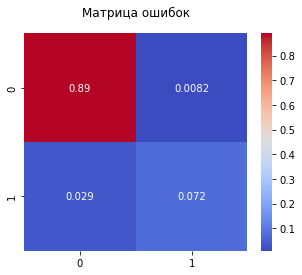

In [22]:
# вывод матрицы ошибок
fig, ax = plt.subplots(figsize=(5, 4))

predictions = svc.predict(test_features)

cm = confusion_matrix(test_target, predictions, normalize='all')

ax.set_title('Матрица ошибок', fontsize='large', y=1.05)
sns.heatmap(cm, annot=True, cmap='coolwarm', ax=ax)

Итоговая метрика для *машины опорных векторов* на *тестовой выборке* оказалось равной **0.79**. Как мы видим, наибольшее количество ошибок приходится на случаи, когда модель пропускает негативные комментарии, не отправляя их на модерацию. Процент таких предсказаний равен **2.9%**. Учитывая, что примерно **10%** *тестовой выборки* приходится на токсичные комментарии, **29%** из них не попадут на модерацию.

## Выводы

Таким образом, мы рассмотрели и подготовили данные, обнаружив при этом дисбаланс классов. Также лемматизировали тексты и векторизировали их с помощью величины *TF-IDF*.

Обучили три вида моделей: модель *логистической регрессии*, *машину опорных векторов* с линейным ядром и ансамбль решающих деревьев, обученных *градиентным бустингом*. У первых двух видов моделей мы меняли *силу обратной регуляризации* `C`, а у ансамблей деревьев — их *глубину* `depth`. Сравнили результаты обучения между собой. Самую высоую *F1-меру* на *обучающей выборке* показала *машина опорных векторов* — **0.78**, модель *логистической регрессии* и модель *градиентного бустинга* показали **0.77** и **0.74** соответственно.

В качестве финальной модели была выбрана *машина опопрных векторов*. На *тестовой выборке* она показала *F1-меру* равную **0.79**. Как оказалось наибольшее количество ошибок приходится на случаи, когда модель пропускает негативные комментарии, не отправляя их на модерацию. Процент таких предсказаний равен **2.9%**. С учетом того, что на токсичные комментарии приходится примерно **10%** *тестовой выборки*, **29%** из них в таком случае не попадут на модерацию.